# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gc

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import matplotlib.image

Num GPUs Available:  1


# Loading the Data

In [2]:
# loading the preprocessed train/valid/test arrays
x_train= np.load("x_train_final_updated.npy")
x_valid= np.load("x_valid_final_updated.npy")
x_test= np.load("x_test_final_updated.npy")

In [3]:
data1= pd.read_pickle("data1.pickle")
# Loading the targets
y_train= data1["y_train"]
y_valid= data1["y_validation"]
y_test= data1["y_test"]

# Deleting data1 to free memory for the model
del data1
gc.collect()

# Loading the labels
labels= pd.read_pickle("updated_labels.pickle")

# Creating the Model

In [4]:
import tensorflow.keras as keras
# num_classes of Signs
num_classes = 43
# One Hot encoding (Dummy coding) the targets
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

In [5]:
# Importing the Sequential model structure
from tensorflow.keras.models import Sequential
# Imprting all the needed layers
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

# Defining the Model Architecture
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, strides=2, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, strides=2, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=num_classes, activation='softmax'))

In [8]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Importing and setting Callbacks
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
# Tuning the learning rate for better precision
learning_rate = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** (x + 50), verbose=1)
# Early stopping to obtain best performance while avoiding overfitting
early_stop= EarlyStopping(min_delta=0.00001, patience=30, restore_best_weights=True)

In [10]:
# Training the Model
history=model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_data=(x_valid,y_valid), callbacks=[early_stop, learning_rate])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0007694497527671316.
680/680 [==============================] - 20s 18ms/step - loss: 1.0231 - accuracy: 0.7347 - val_loss: 0.1833 - val_accuracy: 0.9512
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0007309772651287749.
680/680 [==============================] - 11s 16ms/step - loss: 0.0561 - accuracy: 0.9829 - val_loss: 0.1697 - val_accuracy: 0.9644
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000694428401872336.
680/680 [==============================] - 11s 17ms/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.1194 - val_accuracy: 0.9698
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006597069817787193.
680/680 [==============================] - 11s 17ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.1450 - val_accuracy: 0.9662
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00062

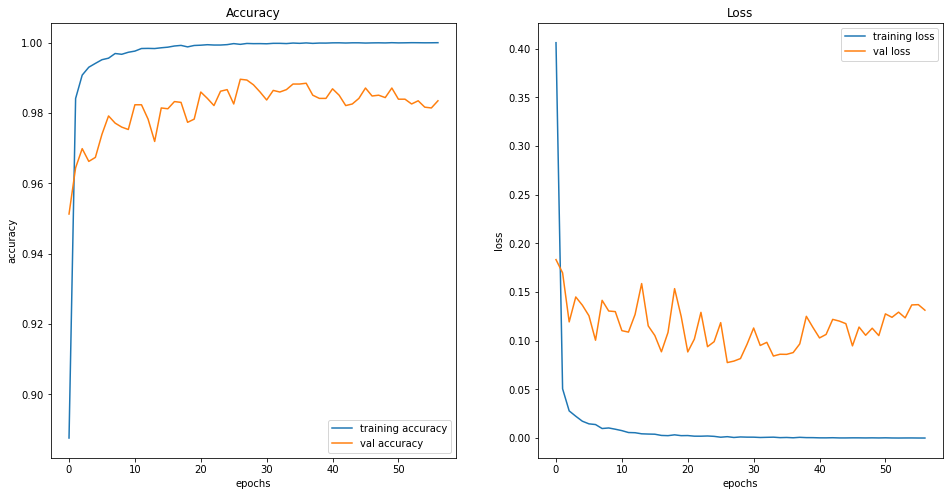

In [11]:
# Plotting the model train and test Accuracy and Loss
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(history.history['accuracy'], label='training accuracy')
ax[0].plot(history.history['val_accuracy'], label='val accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='training loss')
ax[1].plot(history.history['val_loss'], label='val loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
ax[1].legend()
plt.show()

In [55]:
# Verifying the test Score
preds= model.predict(x_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, np.argmax(preds, axis=1))) #0.9772763262074426

0.9772763262074426


<Figure size 2160x2160 with 0 Axes>

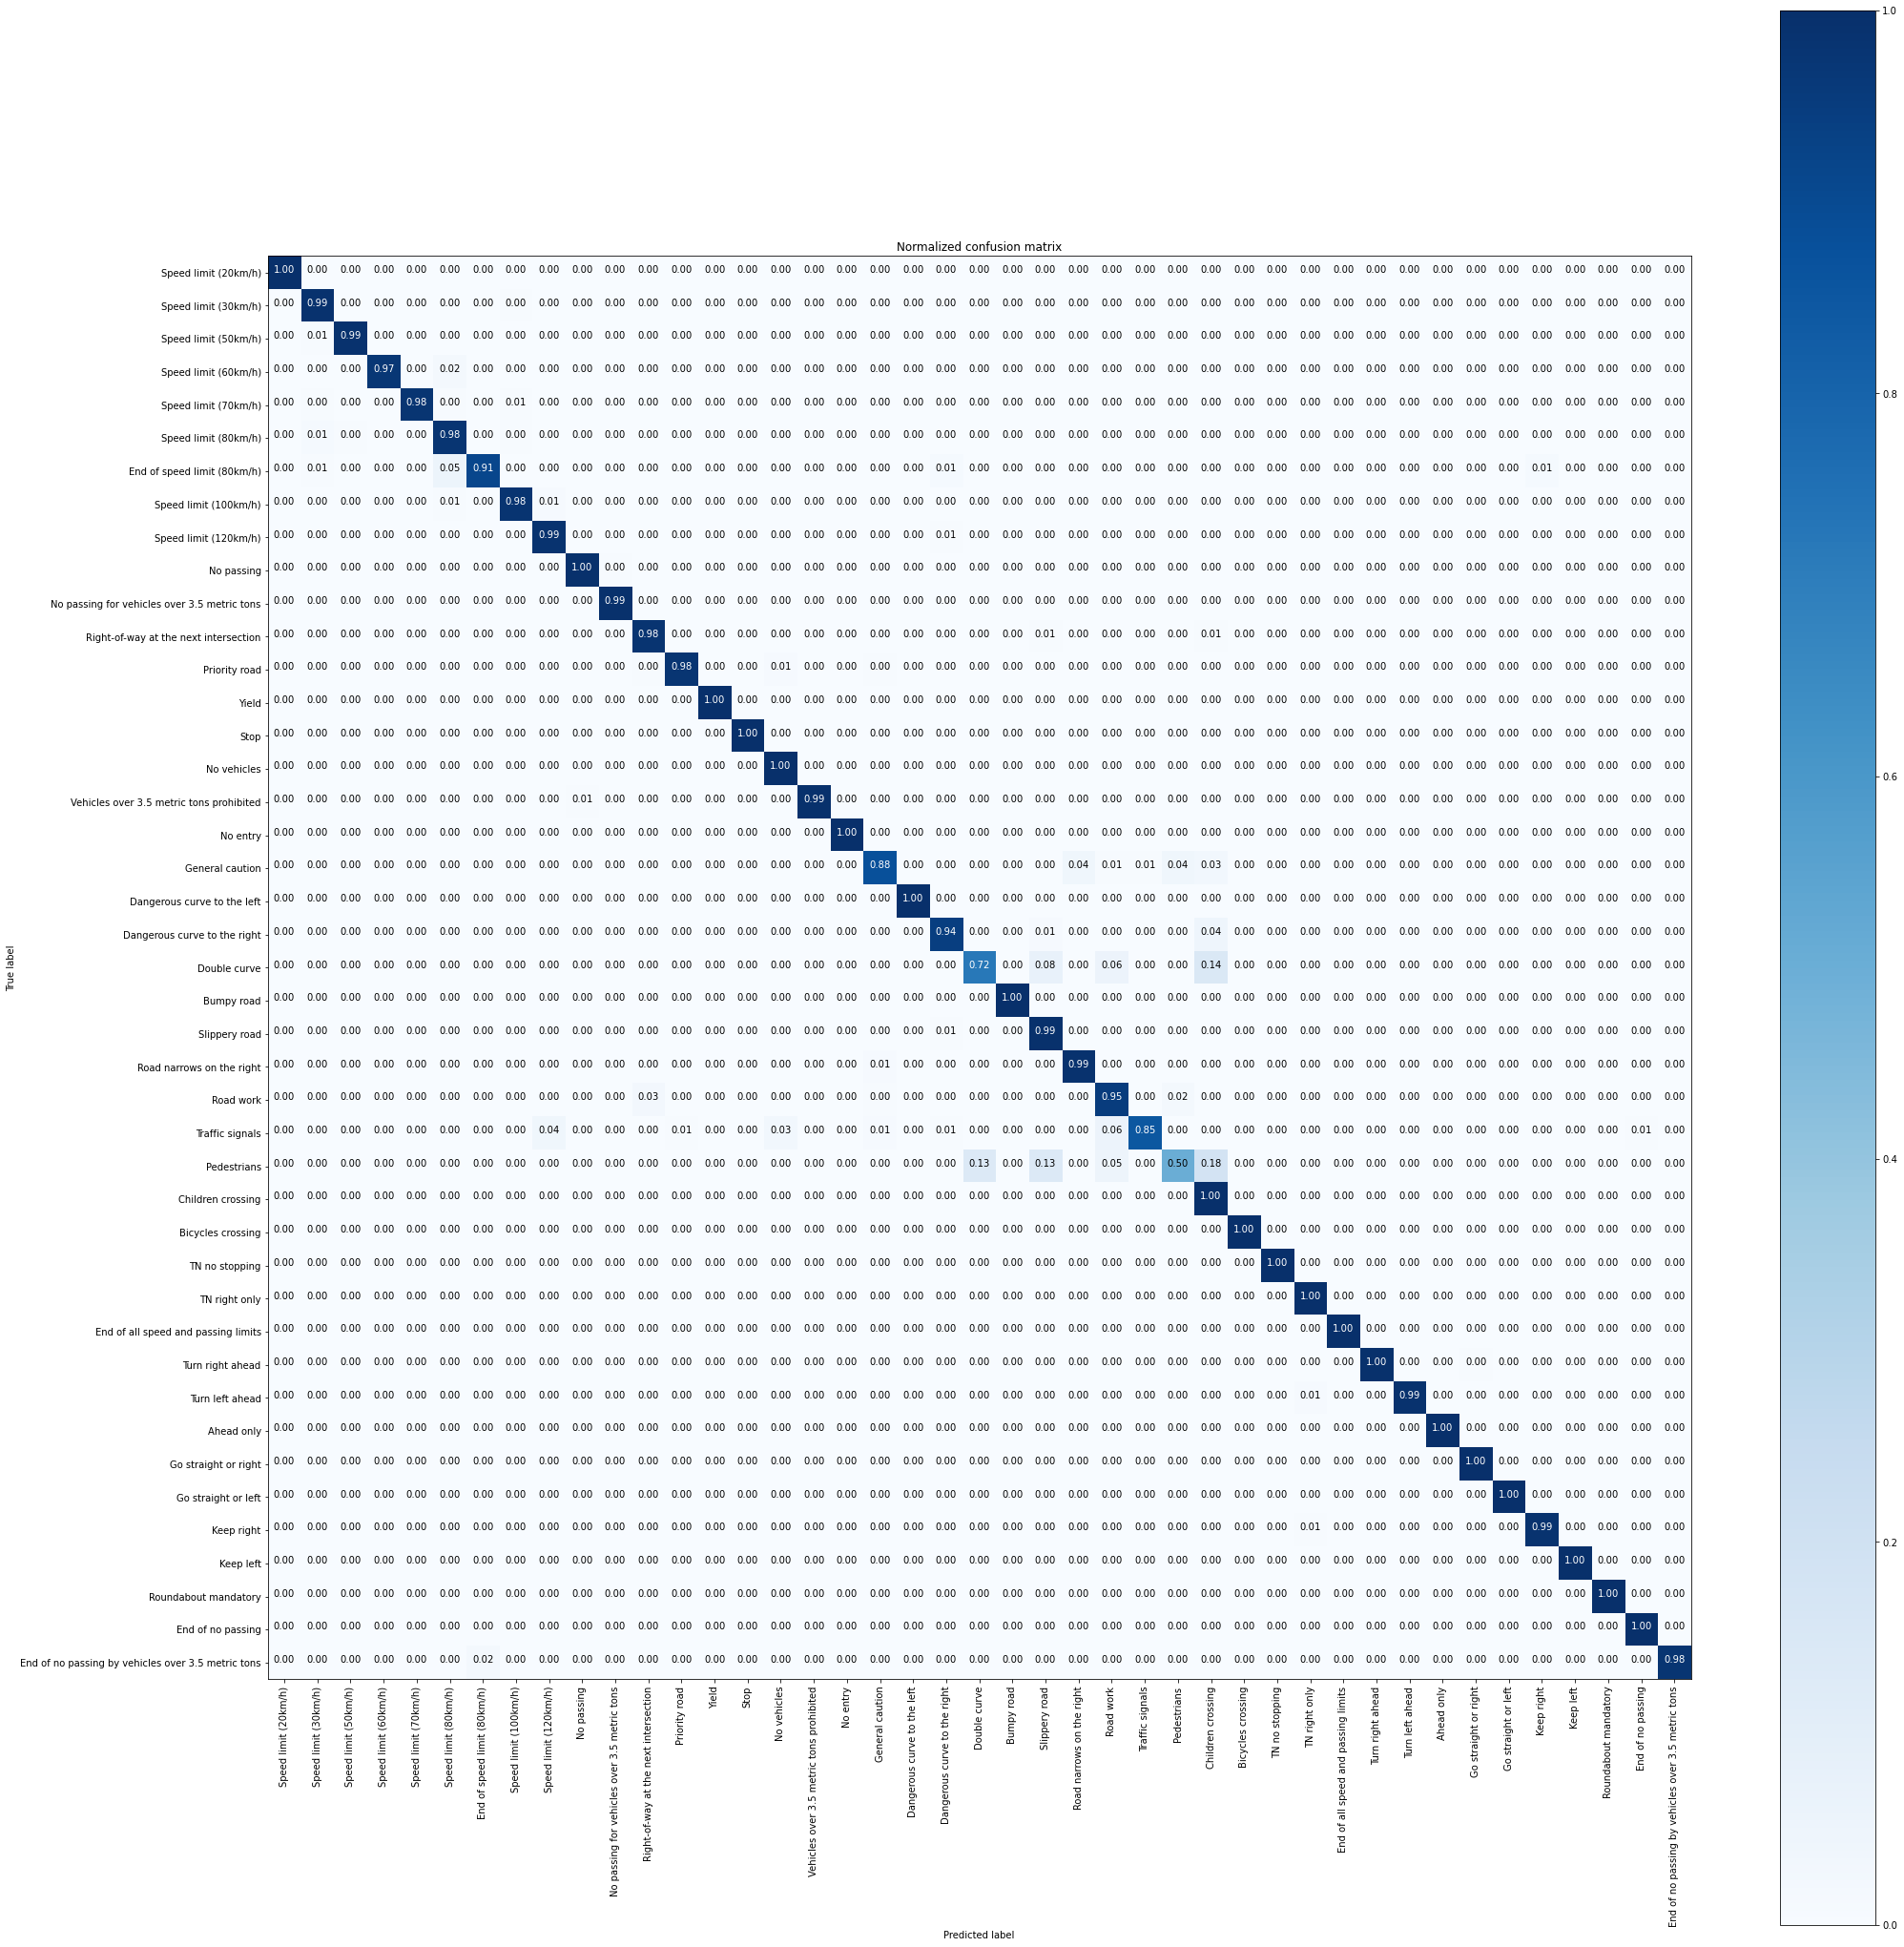

In [13]:
# Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(30,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.argmax(preds, axis=1))
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure(figsize=(30, 30))
plot_confusion_matrix(cnf_matrix, classes=labels, title='Normalized confusion matrix')
plt.show()

In [56]:
# Saving the Model
model.save("TSC_final_updated.h5")